# DeLA Interactive Notebook

Created by: Maosheng Jiang

This notebook is a supplementary educational tool to illustrate how the spatial-regularizer works in the paper: [Decoupled Local Aggregation for Point Cloud Learning](https://arxiv.org/abs/2308.16532).

## Preliminaries 

Traditional local aggregators (e.g. DGCNN, PointNet++) will, at each aggregation layer, recalculate the neighbors in the feature space or in the coordinate space. If a lot of aggregation layers are stacked, then this will become computationally expensive. Decoupled Local Aggregation (DeLA) proposes Decoupled Local Aggregation: we compute and encode the neighbourhood of points beforehand and avoid recomputing this in each successive layer.

![Traditional Aggregation vs Decoupled Local Aggregation](local_aggregation.png)

In the image above, we can see that in the case of DeLA, we only compute the neighborhood once (which then gets encoded within the point features), and the subsequent layer do not have to recompute the neighborhood again.

The downside of this, is that the encoding of the relative distance may degrade deeper into the layers. For that, we employ a spatial regularization term, which essentially trains a small MLP in parallel to keep the encoded relative distance intact within an aggregation layer. This is exactly the technique that we are going to explore in this notebook. For more information about DeLA, please refer to the original paper.

First, let's import the required libraries:

In [43]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.cm as cm
from ipywidgets import interact, IntSlider, Layout

----
## Walkthrough example

To illustrate the regularization term, we will train a simple point cloud network to classify 2D point clouds of handwritten digits (MNIST). This dataset contains 60000 2D point clouds , each consisting of a maximum of 351 2D points with a corresponding value which specifies how large a point is. The test set contains 10000 2D point clouds. For more information, refer to the kaggle source: https://www.kaggle.com/datasets/cristiangarcia/pointcloudmnist2d/data

Now, let's get familiar with the dataset and load it:

In [2]:
TRAIN_PATH = Path("archive/train.csv")
TEST_PATH = Path("archive/test.csv")


def read_data(path):
    return pd.read_csv(path)


def preprocess_data(df):
    X = df[df.columns[1:]].to_numpy()
    y = df[df.columns[0]].to_numpy()

    X = X.reshape((X.shape[0], 351, 3))
    X = X[:, :, :-1] # Drop the value column (not needed)
    y = y.reshape(y.shape[0], 1)

    # X: [60000, 351, 3], y: [60000, 1]
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

X_train, y_train = preprocess_data(read_data(TRAIN_PATH))
X_test, y_test = preprocess_data(read_data(TEST_PATH))

All point clouds have a fixed number of points (351). This is because it is the maximum number of points found in a single point cloud of the dataset. If a point cloud has less than 351 points, then the rest of the points are masked out as -1. So we need to account for this.

Let's visualize a point cloud!

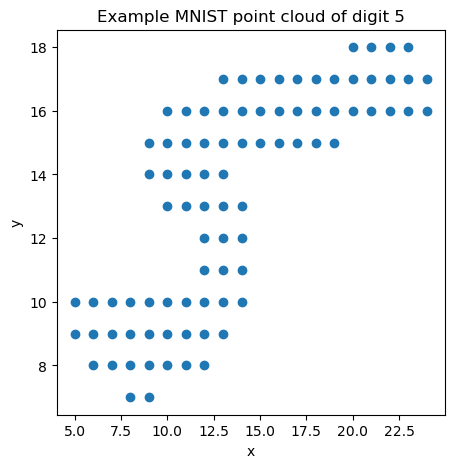

In [3]:
idx = np.random.randint(X_train.shape[0])

pc = X_train[idx]

# Keep only the real points (where x != -1 and y != -1)
pc = pc[(pc[:, 0] != -1) & (pc[:, 1] != -1)]
label = y_train[idx].item()

plt.figure(figsize=(5,5))
plt.scatter(pc[:, 0], pc[:, 1])
plt.title(f"Example MNIST point cloud of digit {int(label)}")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Now we have the MNIST 2D point clouds, let's make the data loader for the train and test dataset.

In [4]:
class PointCloudDataset(Dataset):
    def __init__(self, X, y):
        """
        X: [num_samples, 351, 2] 
        y: [num_samples, 1]
        """
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        pc = self.X[item]
        label = self.y[item]

        # Keep only the real points (where x != -1 and y != -1)
        pc = pc[(pc[:, 0] != -1) & (pc[:, 1] != -1)]

        return pc, label


# Since the point clouds have variable amount of points, we cannot use default batching.
# We need to implement a custom collate_fn which will be passed into the dataloader
# to create a custom batch, which is a list of variable point clouds
def collate_fn(batch):
    coords_list = [item[0] for item in batch]
    labels      = [item[1] for item in batch]
    return coords_list, labels

In [5]:
train_ds = PointCloudDataset(X_train, y_train)
test_ds = PointCloudDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=1, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1, collate_fn=collate_fn, shuffle=True)

---
## Model

Now we have the dataloaders ready, it is time to define a basic 2D point cloud classification model with 3 local aggregation layers with global max pooling.

First we precompute the relative distances of the k neighbors of each point. We are using a basic method that first computes for each point the euclidean distance to all other points. In the original DeLA implementation, the authors used an knn algorithm with KD-Trees which is more efficient.

In [6]:
def knn_indices(pc, k):
    """
    pc: [N,2] point cloud
    returns indices: [N,k] tensor of neighbor indices for each point
    """
    dist = torch.cdist(pc, pc, p=2)
    values, indices = torch.topk(dist, k+1, largest=False, dim=-1)

    # Remove the index of its own point
    return indices[:, 1:]


# Sanity check
test_pc = torch.tensor([[0., 0.],[0., 1.],[0., 2.],[0., 3.]]) # [N, 2] out test point cloud
indices = knn_indices(test_pc, 2) # [N, k] indices of of the neighbors
print(indices)
rel_dist = test_pc[indices] - test_pc.unsqueeze(1) # [N, k, 2] relative distances for each neighbor
print(rel_dist)

tensor([[1, 2],
        [0, 2],
        [1, 3],
        [2, 1]])
tensor([[[ 0.,  1.],
         [ 0.,  2.]],

        [[ 0., -1.],
         [ 0.,  1.]],

        [[ 0., -1.],
         [ 0.,  1.]],

        [[ 0., -1.],
         [ 0., -2.]]])


---
## Defining a standard local aggregation layer

Now, we will define a standard local aggregation layer.

In [7]:
class LocalAggrLayer(nn.Module):
    """
    Standard local aggregation layer
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.mlp = nn.Sequential(
            nn.Linear(in_channels*2 + 2, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels)
        )
        

    def forward(self, pc, knn, rel_dist):
        """
        pc: [N, in_channels] point cloud
        knn: [N, k] precomputed neighbors indices
        rel_dist: [N, k, 2] relative distances
        """

        # A tensor where each point N has the features of its k neighbors
        neighbor_feat = pc[knn] # [N, k, in_channels]

        # A tensor with features of each point
        center_feat = pc.unsqueeze(1).expand_as(neighbor_feat) # [N, k, in_channels]

        # A tensor with relative distances of each neighbor to a point
        rel_dist = rel_dist # [N, k, 2]

        # Now we make up the final feature for each neighbor for message passing: [center_features, neighbor_features, relative_distance]
        message_feat = torch.concat([center_feat, neighbor_feat, rel_dist], dim=2) # [N, k, in_channel*2 + 2]

        result = self.mlp(message_feat) # [N, k, out_channels]

        # Now we aggregate using max (basically a MaxPool)
        values, indices = torch.max(result, dim=1)

        return values


# Sanity check
x = LocalAggrLayer(2, 6) # A layer with 2D input and output 6D feature vector
test_pc = torch.tensor([[0., 0.],[0., 1.],[0., 2.],[0., 3.]]) # Our test point cloud
indices = knn_indices(test_pc, 2) # Calculate the indices of 2 neighbors
relative_distances = test_pc[indices] - test_pc.unsqueeze(1) # The relative distances of each neighbor
x(torch.tensor([[0., 0.],[0., 1.],[0., 2.],[0., 3.]]), indices, relative_distances)

tensor([[-0.2320,  0.4399,  0.1513,  0.0662,  0.5017, -0.3377],
        [-0.3294,  0.6395,  0.3276,  0.1357,  0.3239, -0.2265],
        [-0.3790,  0.6042,  0.3194,  0.1793,  0.2573, -0.2049],
        [-1.0266,  0.7352,  0.5473,  0.1498,  0.0436, -0.0539]],
       grad_fn=<MaxBackward0>)

---
## Model Training

Now that we have defined a normal aggregation layer, let's start training it on our training set. First we will define the hyperparameters.

In [8]:
# These parameters will be utilized for both training the normal and the DeLA version

device = torch.device('cpu')

in_channels = 2
hidden_channels = 16
out_channels = 32
k = 5
classes = 10
learning_rate = 0.001
epochs = 1

Below, we will define our complete network that will predict the MNIST 2D point clouds. Notice that our network consists of 3 of our previously defined local aggregation layers. After applying a global max pool layer (just like in PointNet) we pass it through a fully connected layer to produce our predictions.

In [9]:
class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.layer1 = LocalAggrLayer(in_channels, hidden_channels)
        self.layer2 = LocalAggrLayer(hidden_channels, hidden_channels)
        self.layer3 = LocalAggrLayer(hidden_channels, out_channels)
        self.fc = nn.Linear(out_channels, classes)

    
    def forward(self, pc, knn, rel_dist):
        """
        pc: [N, 2] point cloud
        knn: [N, k] precomputed neighbors indices
        rel_dist: [N, k, 2] relative distances
        """
        x = self.layer1(pc, knn, rel_dist) # [N, in_channels]
        x = self.layer2(x, knn, rel_dist) # [N, hidden_channels]
        x = self.layer3(x, knn, rel_dist) # [N, out_channels]
        
        # Apply global max pooling
        x, _ = torch.max(x, dim=0)

        # Final classification head
        x = self.fc(x)

        return x

Then, we define the model, optimizer, and criterion and run the training loop.

In [10]:
normal_model = GNN(in_channels, hidden_channels, out_channels).to(device)
optimizer = optim.Adam(normal_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(epochs):
    normal_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for points, labels in train_loader:
        batch_loss = 0.0
        correct_in_batch = 0

        # Iterate over each point cloud in the batch
        for i in range(len(points)):
            pc = points[i].to(device)
            label = labels[i].to(device)

            knn = knn_indices(pc, k)

            rel_dist = pc[knn] - pc.unsqueeze(1)

            # Forward pass
            outputs = normal_model(pc, knn, rel_dist)     
            
            # Compute loss
            loss = criterion(outputs.unsqueeze(0), label.long())
            batch_loss += loss
            
            _, predicted = torch.max(outputs, dim=0)
            if predicted == label:
                correct_in_batch += 1

        # Track statistics
        running_loss += batch_loss
        correct += correct_in_batch
        total += len(points)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Print intermediary results each 3200 instances
        if total % 3200 == 0:   
            print(f"Epoch [{epoch+1}] {total}/60000, Accuracy: {correct/total:.2f}")

    # Print statistics after each epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.2f}")

Epoch [1] 3200/60000, Accuracy: 0.30
Epoch [1] 6400/60000, Accuracy: 0.41
Epoch [1] 9600/60000, Accuracy: 0.50
Epoch [1] 12800/60000, Accuracy: 0.56
Epoch [1] 16000/60000, Accuracy: 0.61
Epoch [1] 19200/60000, Accuracy: 0.64
Epoch [1] 22400/60000, Accuracy: 0.67
Epoch [1] 25600/60000, Accuracy: 0.69
Epoch [1] 28800/60000, Accuracy: 0.71
Epoch [1] 32000/60000, Accuracy: 0.73
Epoch [1] 35200/60000, Accuracy: 0.74
Epoch [1] 38400/60000, Accuracy: 0.75
Epoch [1] 41600/60000, Accuracy: 0.76
Epoch [1] 44800/60000, Accuracy: 0.77
Epoch [1] 48000/60000, Accuracy: 0.78
Epoch [1] 51200/60000, Accuracy: 0.79
Epoch [1] 54400/60000, Accuracy: 0.80
Epoch [1] 57600/60000, Accuracy: 0.80
Epoch [1/1], Loss: 0.5729, Accuracy: 0.81


---
## Implementing Decoupled Local Aggregation version

Now as we have seen how a standard local aggregation works, we will move on to the most important part of this notebook: DeLA. As mentioned, the downside is the requirement of feeding the relative distances in each layer. DeLA proposes a different way of local aggregation.

In [11]:
class DecoupledLocalAggrLayer(nn.Module):
    """
    Decoupled local aggregation layer
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Feature aggregation MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_channels*2, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels)
        )

        self.cor_head_hidden_dim = 16

        # Prediction MLP for predicting relative coordinates
        self.pred_mlp = nn.Sequential(
            nn.Linear(out_channels, self.cor_head_hidden_dim),
            nn.ReLU(),
            nn.Linear(self.cor_head_hidden_dim, 2)
        )
        

    def forward(self, xyz, knn, rel_dist):
        """
        xyz: [N, in_channels] point cloud
        knn: [N, k] precomputed neighbors indices
        rel_dist: [N, k, 2] relative distances
        """

        # A tensor where each point N has the features of its k neighbors
        neighbor_feat = xyz[knn] # [N, k, in_channels]

        # A tensor with features of each point
        center_feat = xyz.unsqueeze(1).expand_as(neighbor_feat) # [N, k, in_channels]

        # Now we make up the final feature for each neighbor for message passing: [center_features, neighbor_features]
        message_feat = torch.concat([center_feat, neighbor_feat], dim=2) # [N, k, in_channel*2]

        result = self.mlp(message_feat) # [N, k, out_channels]
        
        # Regularization
        if self.training:
            pred_rel = self.pred_mlp(result) # Outputs the predicted relative distance between each center node and neighbor: [N, k, 2] 
            reg_loss = nn.functional.mse_loss(pred_rel, rel_dist) # Compare the prediction with ground truth
        else:
            reg_loss = 0
        
        # Now we aggregate using max (basically a MaxPool)
        values, indices = torch.max(result, dim=1)

        return values, reg_loss


# Sanity check
x = LocalAggrLayer(2, 6) # A layer with 2D input and output 6D feature vector
test_pc = torch.tensor([[0., 0.],[0., 1.],[0., 2.],[0., 3.]]) # Our test point cloud
indices = knn_indices(test_pc, 2) # Calculate the indices of 2 neighbors
relative_distances = test_pc[indices] - test_pc.unsqueeze(1) # The relative distances of each neighbor
x(torch.tensor([[0., 0.],[0., 1.],[0., 2.],[0., 3.]]), indices, relative_distances)

tensor([[ 0.4291, -0.3830, -0.2035,  0.3899, -0.2866,  0.2709],
        [ 0.2808, -0.2037, -0.4318,  0.6268, -0.1754,  0.3229],
        [ 0.2685, -0.3797, -0.6197,  0.7763, -0.1794,  0.3804],
        [-0.0221, -0.4492, -1.0867,  0.8563, -0.1319,  0.3589]],
       grad_fn=<MaxBackward0>)

Our complete network to predict the 2D MNIST point clouds is given below and looks identical to the one before. The only difference is that each layer returns the regularization loss of the prediction of relative distances. This distance must be returned by the network to perform backprop. *Note: Because we have a simple 3 layer network, I hardcoded the total regularization loss as the sum of the three, one could simply add the losses dynamically to use more layers.*

In [12]:
class DeLAGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.layer1 = DecoupledLocalAggrLayer(in_channels, hidden_channels)
        self.layer2 = DecoupledLocalAggrLayer(hidden_channels, hidden_channels)
        self.layer3 = DecoupledLocalAggrLayer(hidden_channels, out_channels)
        self.fc = nn.Linear(out_channels, classes)

    
    def forward(self, xyz, knn, rel_dist):
        x, reg_loss1 = self.layer1(xyz, knn, rel_dist)
        x, reg_loss2 = self.layer2(x, knn, rel_dist)
        x, reg_loss3 = self.layer3(x, knn, rel_dist)
        
        # Apply global max pooling
        x, _ = torch.max(x, dim=0)

        # Final classification head
        x = self.fc(x)

        total_reg_loss = reg_loss1 + reg_loss2 + reg_loss3

        return x, total_reg_loss

Finally, we train the DeLA version of our model using the same hyperparameters as before, so make sure you have ran the cell with the hyperparameters.

In [14]:
dela_model = DeLAGNN(in_channels, hidden_channels, out_channels).to(device)
optimizer = optim.Adam(dela_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(epochs):
    dela_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for points, labels in train_loader:
        batch_loss = 0.0
        correct_in_batch = 0

        # Iterate over each point cloud in the batch
        for i in range(len(points)):
            point_cloud = points[i].to(device)
            label = labels[i].to(device)

            knn = knn_indices(point_cloud, k)

            rel_dist = point_cloud[knn] - point_cloud.unsqueeze(1)

            # Forward pass
            outputs, reg_loss = dela_model(point_cloud, knn, rel_dist)     
            
            # Compute loss
            loss = criterion(outputs.unsqueeze(0), label.long())
            batch_loss += loss + reg_loss
            
            _, predicted = torch.max(outputs, dim=0)
            if predicted == label:
                correct_in_batch += 1

        # Track statistics
        running_loss += batch_loss
        correct += correct_in_batch
        total += len(points)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Print intermediary results each 3200 instances
        if total % 3200 == 0:   
            print(f"Epoch [{epoch+1}] {total}/60000, Accuracy: {correct/total:.2f}")

    # Print statistics after each epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.2f}")

Epoch [1] 3200/60000, Accuracy: 0.30
Epoch [1] 6400/60000, Accuracy: 0.44
Epoch [1] 9600/60000, Accuracy: 0.54
Epoch [1] 12800/60000, Accuracy: 0.59
Epoch [1] 16000/60000, Accuracy: 0.63
Epoch [1] 19200/60000, Accuracy: 0.66
Epoch [1] 22400/60000, Accuracy: 0.69
Epoch [1] 25600/60000, Accuracy: 0.71
Epoch [1] 28800/60000, Accuracy: 0.73
Epoch [1] 32000/60000, Accuracy: 0.74
Epoch [1] 35200/60000, Accuracy: 0.75
Epoch [1] 38400/60000, Accuracy: 0.76
Epoch [1] 41600/60000, Accuracy: 0.77
Epoch [1] 44800/60000, Accuracy: 0.78
Epoch [1] 48000/60000, Accuracy: 0.79
Epoch [1] 51200/60000, Accuracy: 0.79
Epoch [1] 54400/60000, Accuracy: 0.80
Epoch [1] 57600/60000, Accuracy: 0.81
Epoch [1/1], Loss: 0.6498, Accuracy: 0.81


In [15]:
def testNormalGNN():
    """
    Validate the accuracy of the normal model on the testset
    """
    k_neighbors = 5
    normal_model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for points, labels in test_loader:
            for i in range(len(points)):
                point_cloud = points[i].to(device) # [N, 2]
                label = labels[i].to(device)
    
                knn = knn_indices(point_cloud, k_neighbors) # [N, k]
                rel_dist = point_cloud[knn] - point_cloud.unsqueeze(1) # [N, k, 2]
    
                outputs = normal_model(point_cloud, knn, rel_dist)
    
                _, predicted = torch.max(outputs, dim=0)
                if predicted == label:
                    correct += 1
                total += 1
    
    print(f'Test accuracy on normal model: {100 * correct / total:.2f}%')

    
def testDeLAGNN():
    """
    Validate the accuracy of the DeLA model on the testset
    """
    k_neighbors = 5
    dela_model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for points, labels in test_loader:
            for i in range(len(points)):
                point_cloud = points[i].to(device) # [N, 2]
                label = labels[i].to(device)
    
                knn = knn_indices(point_cloud, k_neighbors) # [N, k]
                rel_dist = point_cloud[knn] - point_cloud.unsqueeze(1) # [N, k, 2]
    
                outputs, _ = dela_model(point_cloud, knn, rel_dist)
    
                _, predicted = torch.max(outputs, dim=0)
                if predicted == label:
                    correct += 1
                total += 1
    
    print(f'Test accuracy on DeLA model: {100 * correct / total:.2f}%')

testNormalGNN()
testDeLAGNN()

Test accuracy on normal model: 91.87%
Test accuracy on DeLA model: 91.83%


---
## Visualizing the predictive performance of DeLA
In the cell below, we can predict visualize the relative distance predictions of the prediction MLP inside each layer. As can be seen, the predictions are quite reasonable, even in deeper layers.

You can use the provided slider to select a particular point in the point cloud. If you want to test it on a new random 2D MNIST point cloud, just rerun the cell.

In [73]:
dela_model.eval()

coords, label = train_ds[0]
coords = coords.unsqueeze(0)
pc = coords[0].to(device) # [N, 2]
label = labels[0].item()


k = 5
knn = knn_indices(pc, k)


neighbor_feat = pc[knn] # [N, k, 2]
center_feat = pc.unsqueeze(1).expand_as(neighbor_feat) # [N, k, 2]
center_coords = center_feat
message_feat = torch.cat([center_feat, neighbor_feat], dim=2) # [N, k, 4]

pred_feat = dela_model.layer1.mlp(message_feat) # [N, k, hidden_channels=16]
pred_rel = dela_model.layer1.pred_mlp(pred_feat) # [N, k, 2]
pred_coords = center_coords + pred_rel # [N, k, 2]

pc_np = pc.cpu().numpy()
pred_coords_np = pred_coords.cpu().detach().numpy()
knn_np = knn.cpu().numpy()


def show_pred(i):
    plt.figure(figsize=(10, 9))
    plt.scatter(pc_np[:, 0], pc_np[:, 1], c='lightgray', label='Point cloud')
    plt.scatter(pc_np[i, 0], pc_np[i, 1], c='red', label='Center point', s=60)
    
    colors = cm.tab10(np.linspace(0, 1, k))[:, :3]
    darker_colors = colors * 0
    
    for j in range(k):
        neighbor_idx = knn_np[i, j]
        true_neighbor = pc_np[neighbor_idx]
        predicted_neighbor = pred_coords_np[i, j]
    
        plt.scatter(true_neighbor[0], true_neighbor[1], color=colors[j], label=f'True neighbor {j+1}', s=30)
        plt.scatter(predicted_neighbor[0], predicted_neighbor[1], color=darker_colors[j], marker='x', s=30, label=f'Predicted neighbor {j+1}')

        # Plot lines
        plt.plot([pc_np[i, 0], true_neighbor[0]], [pc_np[i, 1], true_neighbor[1]], color=colors[j], linestyle='--', linewidth=1)
        plt.plot([pc_np[i, 0], predicted_neighbor[0]], [pc_np[i, 1], predicted_neighbor[1]], color=darker_colors[j], linestyle='-', linewidth=1)

    plt.title(f"Predicted neighbor positions, label: {int(label)}")
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=3,
    )
    plt.subplots_adjust(bottom=0.25)
    plt.grid(True)
    plt.axis('equal')
    plt.show()



interact(show_pred, i=IntSlider(min=0, max=pc_np.shape[0] - 1, step=1, value=0, layout=Layout(width='1000px')));

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='1000px'), max=165), Output()), …

In [71]:
dela_model.eval()

coords, label = train_ds[0]
coords = coords.unsqueeze(0)
pc = coords[0].to(device) # [N, 2]
label = labels[0].item()


k = 5
knn = knn_indices(pc, k)
rel_dist = pc[knn] - pc.unsqueeze(1)

# Feed through layer 1 [2 -> 16]
out, _  = dela_model.layer1(pc, knn, rel_dist) # out: [N, hidden_dim=16]

# Feed through layer 2 [16 -> 16]
neighbor_feat = out[knn] # [N, k, 16]
center_feat = out.unsqueeze(1).expand_as(neighbor_feat) # [N, k, 16]
message_feat = torch.cat([center_feat, neighbor_feat], dim=2) # [N, k, 16*2]

pred_feat = dela_model.layer2.mlp(message_feat) # [N, k, 16]
pred_rel = dela_model.layer2.pred_mlp(pred_feat) # [N, k, 2]
pred_coords = center_coords + pred_rel # [N, k, 2]

pc_np = pc.cpu().numpy()
pred_coords_np = pred_coords.cpu().detach().numpy()
knn_np = knn.cpu().numpy()


def show_pred(i):
    plt.figure(figsize=(10, 9))
    plt.scatter(pc_np[:, 0], pc_np[:, 1], c='lightgray', label='Point cloud')
    plt.scatter(pc_np[i, 0], pc_np[i, 1], c='red', label='Center point', s=60)
    
    colors = cm.tab10(np.linspace(0, 1, k))[:, :3]
    darker_colors = colors * 0
    
    for j in range(k):
        neighbor_idx = knn_np[i, j]
        true_neighbor = pc_np[neighbor_idx]
        predicted_neighbor = pred_coords_np[i, j]
    
        plt.scatter(true_neighbor[0], true_neighbor[1], color=colors[j], label=f'True neighbor {j+1}', s=30)
        plt.scatter(predicted_neighbor[0], predicted_neighbor[1], color=darker_colors[j], marker='x', s=30, label=f'Predicted neighbor {j+1}')

        # Plot lines
        plt.plot([pc_np[i, 0], true_neighbor[0]], [pc_np[i, 1], true_neighbor[1]], color=colors[j], linestyle='--', linewidth=1)
        plt.plot([pc_np[i, 0], predicted_neighbor[0]], [pc_np[i, 1], predicted_neighbor[1]], color=darker_colors[j], linestyle='-', linewidth=1)

    plt.title(f"Predicted neighbor positions, label: {int(label)}")
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=3,
    )
    plt.subplots_adjust(bottom=0.25)
    plt.grid(True)
    plt.axis('equal')
    plt.show()



interact(show_pred, i=IntSlider(min=0, max=pc_np.shape[0] - 1, step=1, value=0, layout=Layout(width='1000px')));


interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='1000px'), max=165), Output()), …

In [72]:
dela_model.eval()

coords, label = train_ds[0]
coords = coords.unsqueeze(0)
pc = coords[0].to(device) # [N, 2]
label = labels[0].item()


k = 5
knn = knn_indices(pc, k)
rel_dist = pc[knn] - pc.unsqueeze(1)

# Feed through layer 1 [2 -> 16]
out, _  = dela_model.layer1(pc, knn, rel_dist) # out: [N, hidden_dim=16]

# Feed through layer 2 [16 -> 16]
out, _  = dela_model.layer2(out, knn, rel_dist) # out: [N, hidden_dim=16]

# Feed through layer 3 [16 -> 32]
neighbor_feat = out[knn] # [N, k, 16]
center_feat = out.unsqueeze(1).expand_as(neighbor_feat) # [N, k, 16]
message_feat = torch.cat([center_feat, neighbor_feat], dim=2) # [N, k, 16*2]

pred_feat = dela_model.layer3.mlp(message_feat) # [N, k, 32]
pred_rel = dela_model.layer3.pred_mlp(pred_feat) # [N, k, 2]
pred_coords = center_coords + pred_rel # [N, k, 2]

pc_np = pc.cpu().numpy()
pred_coords_np = pred_coords.cpu().detach().numpy()
knn_np = knn.cpu().numpy()


def show_pred(i):
    plt.figure(figsize=(10, 9))
    plt.scatter(pc_np[:, 0], pc_np[:, 1], c='lightgray', label='Point cloud')
    plt.scatter(pc_np[i, 0], pc_np[i, 1], c='red', label='Center point', s=60)
    
    colors = cm.tab10(np.linspace(0, 1, k))[:, :3]
    darker_colors = colors * 0
    
    for j in range(k):
        neighbor_idx = knn_np[i, j]
        true_neighbor = pc_np[neighbor_idx]
        predicted_neighbor = pred_coords_np[i, j]
    
        plt.scatter(true_neighbor[0], true_neighbor[1], color=colors[j], label=f'True neighbor {j+1}', s=30)
        plt.scatter(predicted_neighbor[0], predicted_neighbor[1], color=darker_colors[j], marker='x', s=30, label=f'Predicted neighbor {j+1}')

        # Plot lines
        plt.plot([pc_np[i, 0], true_neighbor[0]], [pc_np[i, 1], true_neighbor[1]], color=colors[j], linestyle='--', linewidth=1)
        plt.plot([pc_np[i, 0], predicted_neighbor[0]], [pc_np[i, 1], predicted_neighbor[1]], color=darker_colors[j], linestyle='-', linewidth=1)

    plt.title(f"Predicted neighbor positions, label: {int(label)}")
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=3,
    )
    plt.subplots_adjust(bottom=0.25)
    plt.grid(True)
    plt.axis('equal')
    plt.show()



interact(show_pred, i=IntSlider(min=0, max=pc_np.shape[0] - 1, step=1, value=0, layout=Layout(width='1000px')));


interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='1000px'), max=165), Output()), …

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='1000px'), max=165), Output()), …

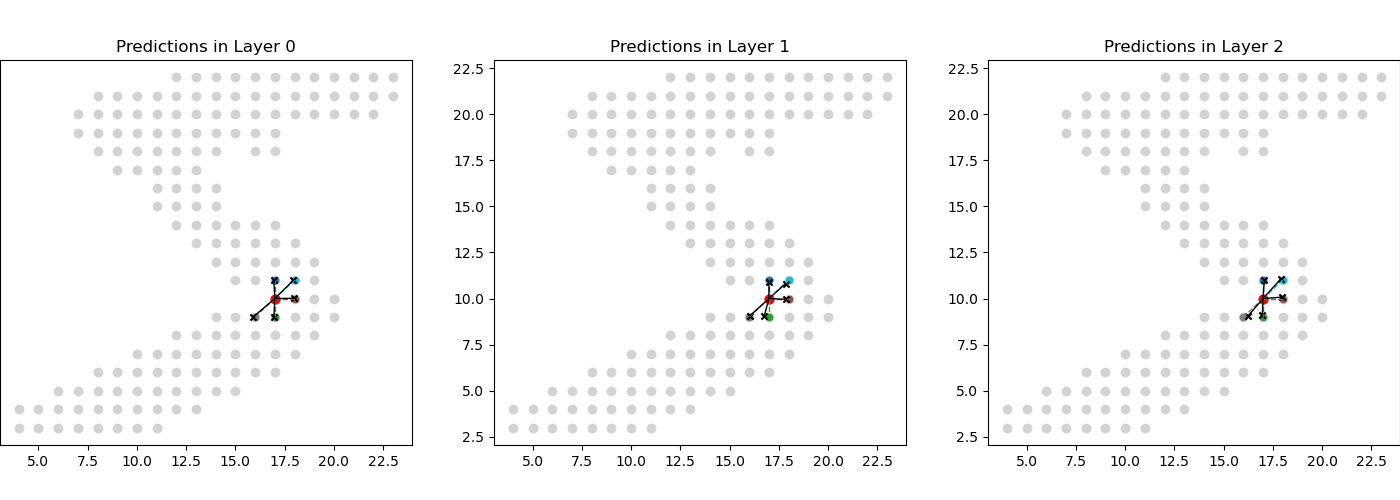

In [116]:
dela_model.eval()

coords, label = train_ds[0]
coords = coords.unsqueeze(0)
pc = coords[0].to(device) # [N, 2]
label = label[0].item()


k = 5
knn = knn_indices(pc, k)


# Compute predicted relative distances in layer 1
neighbor_feat = pc[knn] # [N, k, 2]
center_feat = pc.unsqueeze(1).expand_as(neighbor_feat) # [N, k, 2]
center_coords = center_feat
message_feat = torch.cat([center_feat, neighbor_feat], dim=2) # [N, k, 4]

pred_feat = dela_model.layer1.mlp(message_feat) # [N, k, hidden_channels=16]
pred_rel = dela_model.layer1.pred_mlp(pred_feat) # [N, k, 2]
pred_coords = center_coords + pred_rel # [N, k, 2]

pc_np = pc.cpu().numpy()
knn_np = knn.cpu().numpy()
pred_coords_1_np = pred_coords.cpu().detach().numpy()



# Comptute predicted relative distances in layer 2
# Feed through layer 1 [2 -> 16]
out, _  = dela_model.layer1(pc, knn, rel_dist) # out: [N, hidden_dim=16]

# Feed through layer 2 [16 -> 16]
neighbor_feat = out[knn] # [N, k, 16]
center_feat = out.unsqueeze(1).expand_as(neighbor_feat) # [N, k, 16]
message_feat = torch.cat([center_feat, neighbor_feat], dim=2) # [N, k, 16*2]

pred_feat = dela_model.layer2.mlp(message_feat) # [N, k, 16]
pred_rel = dela_model.layer2.pred_mlp(pred_feat) # [N, k, 2]
pred_coords = center_coords + pred_rel # [N, k, 2]

pred_coords_2_np = pred_coords.cpu().detach().numpy()


# Computepredicted relative distances in layer 3
# Feed through layer 1 [2 -> 16]
out, _  = dela_model.layer1(pc, knn, rel_dist) # out: [N, hidden_dim=16]

# Feed through layer 2 [16 -> 16]
out, _  = dela_model.layer2(out, knn, rel_dist) # out: [N, hidden_dim=16]

# Feed through layer 3 [16 -> 32]
neighbor_feat = out[knn] # [N, k, 16]
center_feat = out.unsqueeze(1).expand_as(neighbor_feat) # [N, k, 16]
message_feat = torch.cat([center_feat, neighbor_feat], dim=2) # [N, k, 16*2]

pred_feat = dela_model.layer3.mlp(message_feat) # [N, k, 32]
pred_rel = dela_model.layer3.pred_mlp(pred_feat) # [N, k, 2]
pred_coords = center_coords + pred_rel # [N, k, 2]

pred_coords_3_np = pred_coords.cpu().detach().numpy()


data = [pred_coords_1_np, pred_coords_2_np, pred_coords_3_np]


fig, axes = plt.subplots(1, 3, figsize=(14, 5))
# fig.subplots_adjust(top=0.98, bottom=0.02)
fig.subplots_adjust(left=0, right=1)


def show_pred(i):
    
    for idx, ax in enumerate(axes):
        ax.clear()
        # plt.figure(figsize=(10, 9))
        ax.scatter(pc_np[:, 0], pc_np[:, 1], c='lightgray', label='Point cloud')
        ax.scatter(pc_np[i, 0], pc_np[i, 1], c='red', label='Center point', s=40)
        
        colors = cm.tab10(np.linspace(0, 1, k))[:, :3]
        darker_colors = colors * 0
        
        for j in range(k):
            neighbor_idx = knn_np[i, j]
            true_neighbor = pc_np[neighbor_idx]
            predicted_neighbor = data[idx][i, j]
        
            ax.scatter(true_neighbor[0], true_neighbor[1], color=colors[j], label=f'True neighbor {j+1}', s=20)
            ax.scatter(predicted_neighbor[0], predicted_neighbor[1], color=darker_colors[j], marker='x', s=20, label=f'Predicted neighbor {j+1}')
    
            # Plot lines
            ax.plot([pc_np[i, 0], true_neighbor[0]], [pc_np[i, 1], true_neighbor[1]], color=colors[j], linestyle='--', linewidth=1)
            ax.plot([pc_np[i, 0], predicted_neighbor[0]], [pc_np[i, 1], predicted_neighbor[1]], color=darker_colors[j], linestyle='-', linewidth=1)
    
        ax.set_title(f"Predictions in Layer {idx}")
        # plt.legend(
        #     loc='upper center',
        #     bbox_to_anchor=(0.5, -0.1),
        #     ncol=3,
        # )
        # plt.subplots_adjust(bottom=0.25)
        # plt.grid(True)
        # plt.axis('equal')
        # plt.show()



interact(show_pred, i=IntSlider(min=0, max=pc_np.shape[0] - 1, step=1, value=0, layout=Layout(width='1000px')));